# Simulation of two IDPs: aSyn and FUSRGG3

In [1]:
import MDAnalysis as mda

In [2]:
uni = mda.Universe("top.pdb", "sim.dcd")
uni

/home/sujaly/anaconda3/envs/MDAnalysis/lib/python3.13/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


<Universe with 174 atoms>

I should have two segments in my universe. Let's verify that

In [3]:
print("Number of segments:", uni.segments.n_segments)

Number of segments: 2


I want to check how distance between center of mass of both protein changes with time.

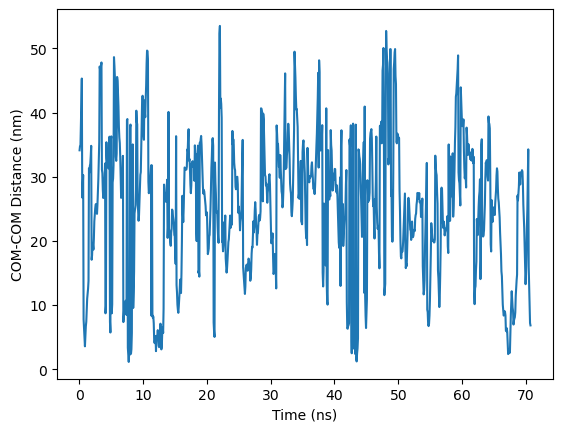

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def calc_distance(corr_list1, corr_list2):
    arr1 = np.array(corr_list1)
    arr2 = np.array(corr_list2)

    dis = np.linalg.norm(arr1 - arr2)

    return dis
    

frames = len(uni.trajectory)
coms_dist = np.array([])
time = np.array([])

fusrgg3 = uni.select_atoms(f"segid A")
asyn = uni.select_atoms(f"segid B")

for ts in uni.trajectory:
    time = np.append(time, uni.trajectory.time)

    fusrgg3_com = fusrgg3.center_of_mass()
    asyn_com = asyn.center_of_mass()

    dist = calc_distance(fusrgg3_com, asyn_com)

    coms_dist = np.append(coms_dist, dist)

plt.plot(time*0.001, coms_dist*0.1)
plt.xlabel('Time (ns)')
plt.ylabel("COM-COM Distance (nm)")
plt.show()

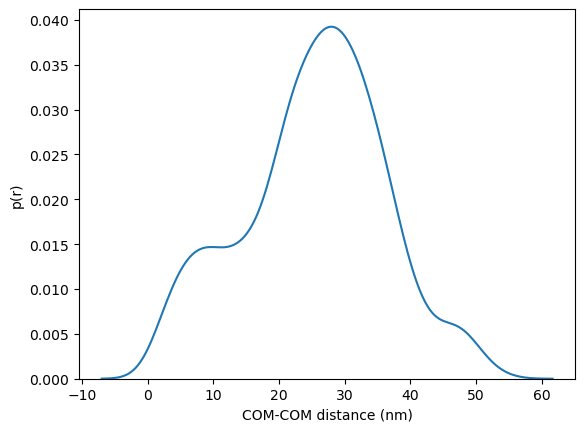

In [5]:
import seaborn as sns

sns.kdeplot(coms_dist*0.1)
plt.xlabel("COM-COM distance (nm)")
plt.ylabel("p(r)")
plt.show()

In [21]:
def contact_analysis(uni, bottom, top, cutoff=5):  # cutoff is in nm

    length = len(uni.trajectory)
    resid = bottom.atoms.resids
    prob_dist = np.zeros(bottom.n_atoms)  # Preallocate probabilities

    for ts in uni.trajectory:  # Iterate over trajectory frames
        bottom_positions = bottom.atoms.positions  # Get positions of bottom atoms
        top_positions = top.atoms.positions  # Get positions of top atoms
        
        # Efficient distance computation using NumPy broadcasting
        distances = np.linalg.norm(bottom_positions[:, np.newaxis, :] - top_positions[np.newaxis, :, :], axis=2)*0.1
        
        
        contacts = distances < cutoff  # Boolean matrix of contacts
        
        prob_dist += np.mean(contacts, axis=1)  # Accumulate fraction of frames

    prob_dist /= length  # Normalize by trajectory length

    return prob_dist.tolist(), resid

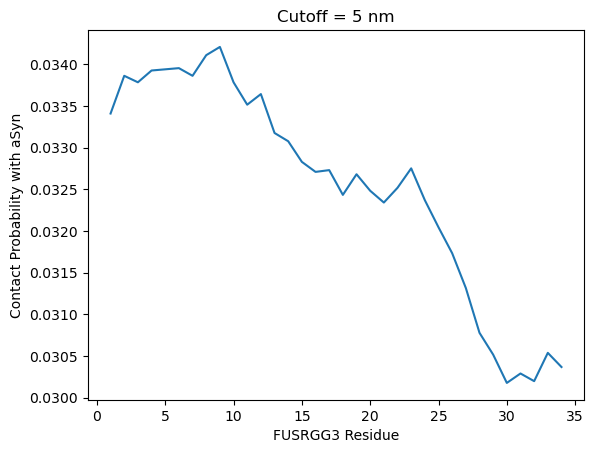

In [23]:
dis, res = contact_analysis(uni,fusrgg3, asyn)
plt.plot(res, dis)
plt.xlabel("FUSRGG3 Residue")
plt.ylabel("Contact Probability with aSyn")
plt.title("Cutoff = 5 nm")
plt.show()

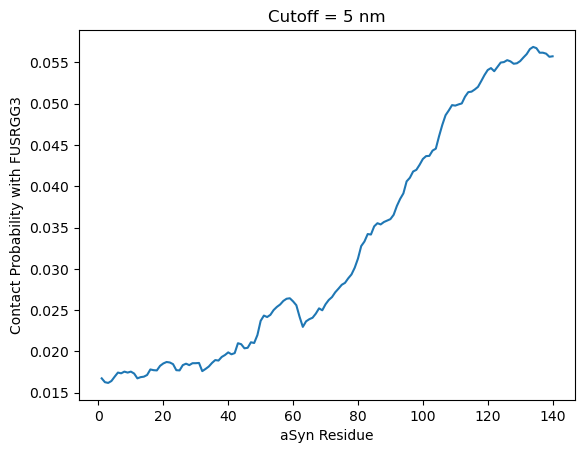

In [24]:
dis, res = contact_analysis(uni,asyn, fusrgg3)
plt.plot(res, dis)
plt.xlabel("aSyn Residue")
plt.ylabel("Contact Probability with FUSRGG3")
plt.title("Cutoff = 5 nm")
plt.show()